In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy.ma as ma
import glob
from collections import namedtuple, OrderedDict
import netCDF4 as nc
import os
import scipy
import scipy.io as sio
from scipy import interpolate, signal
from pyproj import Proj,transform
import sys
sys.path.append('/ocean/ssahu/CANYONS/wcvi/grid/')
from bathy_common import *
from matplotlib import path
from salishsea_tools import viz_tools
import xarray as xr
from salishsea_tools import nc_tools
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.gridspec as gridspec
%matplotlib inline
from scipy.io import loadmat
from scipy.interpolate import griddata
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools, tidetools, nc_tools
import gsw
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import seaborn as sns
from windrose import plot_windrose
from windrose import WindroseAxes


from dateutil        import parser
from datetime import datetime

sns.set_context('poster')
sns.set_style('dark')

/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


# nc_file = nc.Dataset('/data/ssahu/ARIANE/LB_08/LB_08_big_box.nc')

nc_file = nc.Dataset('/data/ssahu/ARIANE/LB_08/LB_08_big_sequential.nc')
nc_tools.show_variables(nc_file)

odict_keys(['init_x', 'init_y', 'init_z', 'init_t', 'init_age', 'init_transp', 'final_x', 'final_y', 'final_z', 'final_t', 'final_age', 'final_transp', 'traj_lon', 'traj_lat', 'traj_depth', 'traj_time', 'traj_temp', 'traj_salt', 'traj_dens'])


In [3]:


init_x = nc_file.variables['init_x']
init_z = nc_file.variables['init_z']
init_age = nc_file.variables['init_age']

traj_depth = nc_file.variables['traj_depth'][:]
traj_lon   = nc_file.variables['traj_lon'][:]
traj_lat   = nc_file.variables['traj_lat'][:]
traj_rho   = nc_file.variables['traj_dens'][:]
traj_tem   = nc_file.variables['traj_temp'][:]
traj_sal   = nc_file.variables['traj_salt'][:]
traj_time  = nc_file.variables['traj_time']


final_age = nc_file.variables['final_age']


# lon1=nc_file.variables['traj_lon'][:]
# lat1=nc_file.variables['traj_lat'][:]
# dep1=nc_file.variables['traj_depth'][:]
x1=nc_file.variables['init_x'][:]
y1=nc_file.variables['init_y'][:]
t1=nc_file.variables['traj_time'][:]

x2=nc_file.variables['final_x'][:]
y2=nc_file.variables['final_y'][:]


final_z = nc_file.variables['final_z'][:]

final_age_days = final_age[:]/(3600)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


In [4]:
x_final = []
y_final = []


for i in np.arange(x2.shape[0]):
    x_final = np.append(arr=x_final,values=x_wcvi_slice[np.int(np.rint(x2[i]))-1])
    y_final = np.append(arr=y_final,values=y_wcvi_slice[np.int(np.rint(y2[i]))-1])

In [7]:
def U_timeseries_at_WCVI_locations(grid_U):
    
    u_vel = grid_U.variables['uo'][:,:,:,:]

    
    vector_u = namedtuple('vector_u', 'u_vel')

    return vector_u(u_vel)


def V_timeseries_at_WCVI_locations(grid_V):
    
    v_vel = grid_V.variables['vo'][:,:,:,:]

    
    vector_v = namedtuple('vector_v', 'v_vel')

    return vector_v(v_vel)

In [9]:
file_u = '/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/cut_NEP36-S29_1d_20130429_20130826_grid_U.nc'
file_v = '/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/cut_NEP36-S29_1d_20130429_20130826_grid_V.nc'


u_vel = U_timeseries_at_WCVI_locations(nc.Dataset(file_u))[0]
v_vel = V_timeseries_at_WCVI_locations(nc.Dataset(file_v))[0]

u_tzyx, v_tzyx = viz_tools.unstagger(u_vel, v_vel)

mag_vel = np.sqrt(np.multiply(u_tzyx,u_tzyx) +  np.multiply(v_tzyx,v_tzyx));
ang_vel = np.degrees(np.arctan2(v_tzyx, u_tzyx))

u_unrotated = u_tzyx
v_unrotated = v_tzyx



In [11]:
ind = np.array(np.where((84<-1*traj_depth[0,:]) & (-1*traj_depth[0,:] <85)))[0]

In [104]:
ind[139]

4094

In [105]:
ind[200]

5570

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


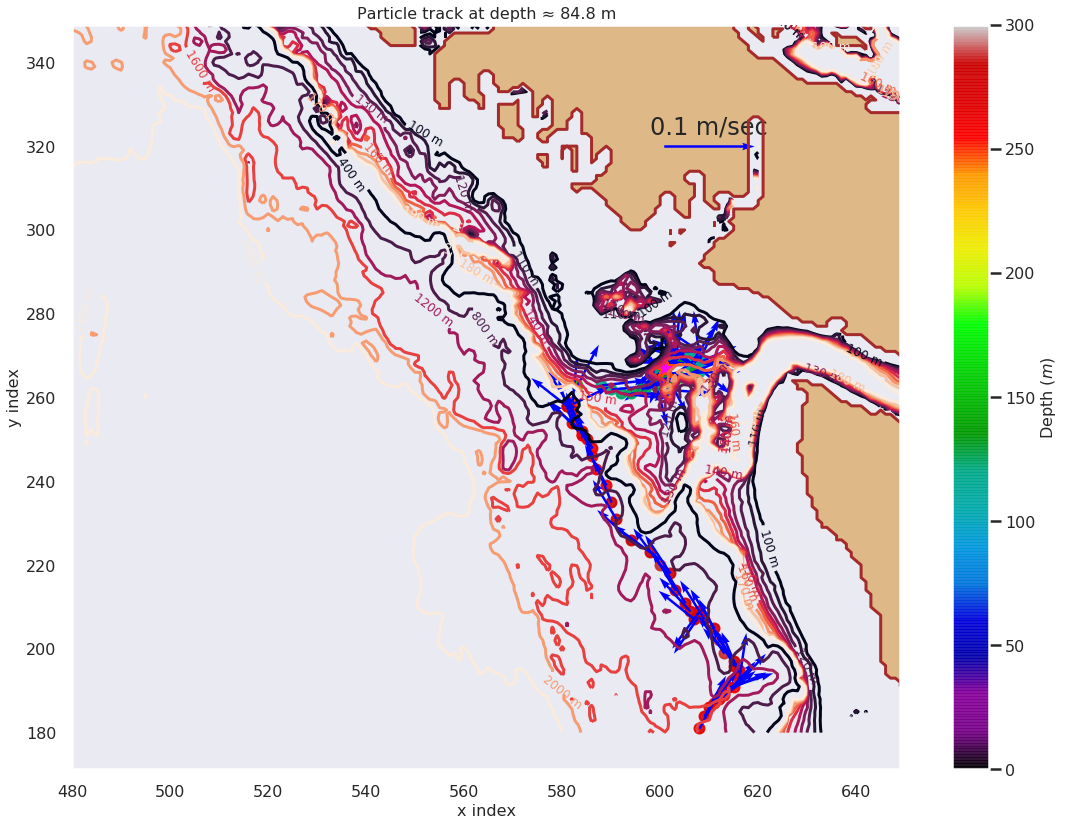

In [103]:
bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]



file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

lon_small = file_model.variables['nav_lon'][1:,1:]
lat_small = file_model.variables['nav_lat'][1:,1:]




cmap=plt.cm.get_cmap('nipy_spectral')
#     cmap = plt.cm.get_cmap('gist_rainbow')
cmap.set_bad('#8b7765')
cmin = 0
cmax = 300

import matplotlib as mpl
#     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)


# part = ind[0]
# for part in ind[139]:
part = ind[139]
for k in np.arange(0,np.int(final_age_days[part]),30):
    y, x = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                  lon,lat,grid='NEMO',tols=\
                                  {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                   'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
    track1 = ax.scatter(x_wcvi_slice[np.int(np.rint(x1[part]))-1], y_wcvi_slice[np.int(np.rint(y1[part]))-1], s=500, marker = '*', c = 'magenta', alpha=0.9, edgecolor= 'orangered')
    q = ax.scatter(x, y, c = np.multiply(-1,np.ma.array(traj_depth[k,part]).filled()), cmap = cmap, vmin = cmin, vmax= cmax, s=100, alpha=0.9)#, edgecolor= 'cyan')

    t = np.int(np.rint(120 - traj_time[k,part]*120))
    level = np.int(np.rint((np.abs(zlevels - (-traj_depth[k,part]))).argmin()))

    u_vel_time_level = u_vel[t-1,level,...]
    v_vel_time_level = v_vel[t-1,level,...]
    # for level in np.arange(zlevels.shape[0]):
    u_tzyx[...], v_tzyx[...] = viz_tools.unstagger(u_vel_time_level, v_vel_time_level)

    j, i = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                              lon_small,lat_small,grid='NEMO',tols=\
                                              {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                               'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 

    # u_tzyx_loc = np.empty((zlevels.shape[0]))
    # v_tzyx_loc = np.empty_like(u_tzyx_loc)

    u_tzyx_loc = u_tzyx[t-1,level,j,i]
    v_tzyx_loc = v_tzyx[t-1,level,j,i]
    
    speeds = np.sqrt(np.square(u_tzyx_loc) + np.square(v_tzyx_loc))
#     quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step,::arrow_step], pivot='mid', cmap = cmap, width=0.005, minshaft= 0.5)
    quiver = ax.quiver(x, y, u_tzyx_loc, v_tzyx_loc , color = 'blue', cmap = cmap, pivot='tail', width=0.003, minshaft= 0.5)
#     legend = ax.legend(loc='best', fancybox=True, framealpha=0.25, fontsize =16)
ax.quiverkey(quiver, 610, 320,  0.1, r'0.1 m/sec', coordinates = 'data')

ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)


ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
ax.legend(loc = 'best')

viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

ax.grid()

cbar = fig.colorbar(q, ax=ax)
cbar.set_label(label='Depth ($m$)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)
fig.tight_layout()





/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


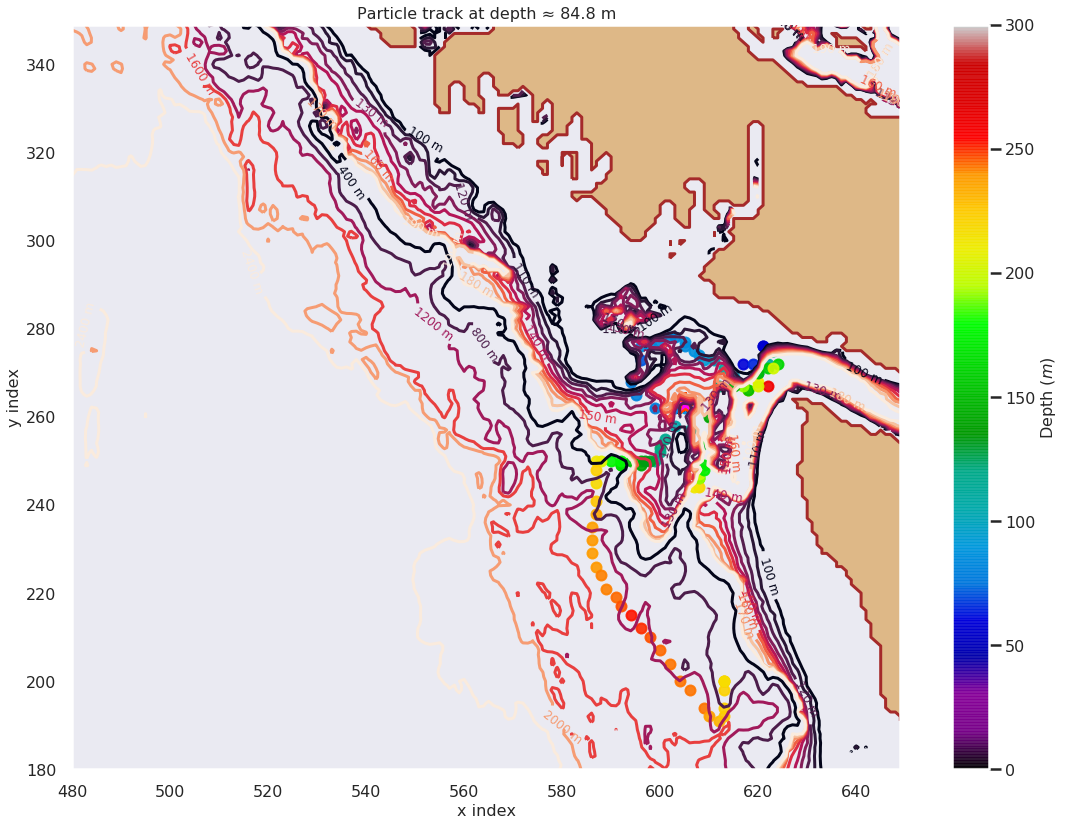

In [107]:
bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]



file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

lon_small = file_model.variables['nav_lon'][1:,1:]
lat_small = file_model.variables['nav_lat'][1:,1:]




cmap=plt.cm.get_cmap('nipy_spectral')
#     cmap = plt.cm.get_cmap('gist_rainbow')
cmap.set_bad('#8b7765')
cmin = 0
cmax = 300

import matplotlib as mpl
#     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)


# part = ind[0]
# for part in ind[139]:
part = ind[200]
for k in np.arange(0,np.int(final_age_days[part]),30):
    y, x = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                  lon,lat,grid='NEMO',tols=\
                                  {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                   'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
    track1 = ax.scatter(x_wcvi_slice[np.int(np.rint(x1[part]))-1], y_wcvi_slice[np.int(np.rint(y1[part]))-1], s=500, marker = '*', c = 'magenta', alpha=0.9, edgecolor= 'orangered')
    q = ax.scatter(x, y, c = np.multiply(-1,np.ma.array(traj_depth[k,part]).filled()), cmap = cmap, vmin = cmin, vmax= cmax, s=100, alpha=0.9)#, edgecolor= 'cyan')

    t = np.int(np.rint(120 - traj_time[k,part]*120))
    level = np.int(np.rint((np.abs(zlevels - (-traj_depth[k,part]))).argmin()))

    u_vel_time_level = u_vel[t-1,level,...]
    v_vel_time_level = v_vel[t-1,level,...]
    # for level in np.arange(zlevels.shape[0]):
    u_tzyx[...], v_tzyx[...] = viz_tools.unstagger(u_vel_time_level, v_vel_time_level)

    j, i = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                              lon_small,lat_small,grid='NEMO',tols=\
                                              {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                               'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 

    # u_tzyx_loc = np.empty((zlevels.shape[0]))
    # v_tzyx_loc = np.empty_like(u_tzyx_loc)

    u_tzyx_loc = u_tzyx[t-1,level,j,i]
    v_tzyx_loc = v_tzyx[t-1,level,j,i]
    
    speeds = np.sqrt(np.square(u_tzyx_loc) + np.square(v_tzyx_loc))
#     quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step,::arrow_step], pivot='mid', cmap = cmap, width=0.005, minshaft= 0.5)
#     quiver = ax.quiver(x, y, u_tzyx_loc, v_tzyx_loc , color = 'blue', cmap = cmap, pivot='tail', width=0.003, minshaft= 0.5)
# #     legend = ax.legend(loc='best', fancybox=True, framealpha=0.25, fontsize =16)
# ax.quiverkey(quiver, 610, 320,  0.1, r'0.1 m/sec', coordinates = 'data')

ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)


ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
ax.legend(loc = 'best')

viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

ax.grid()

cbar = fig.colorbar(q, ax=ax)
cbar.set_label(label='Depth ($m$)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)
fig.tight_layout()





/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


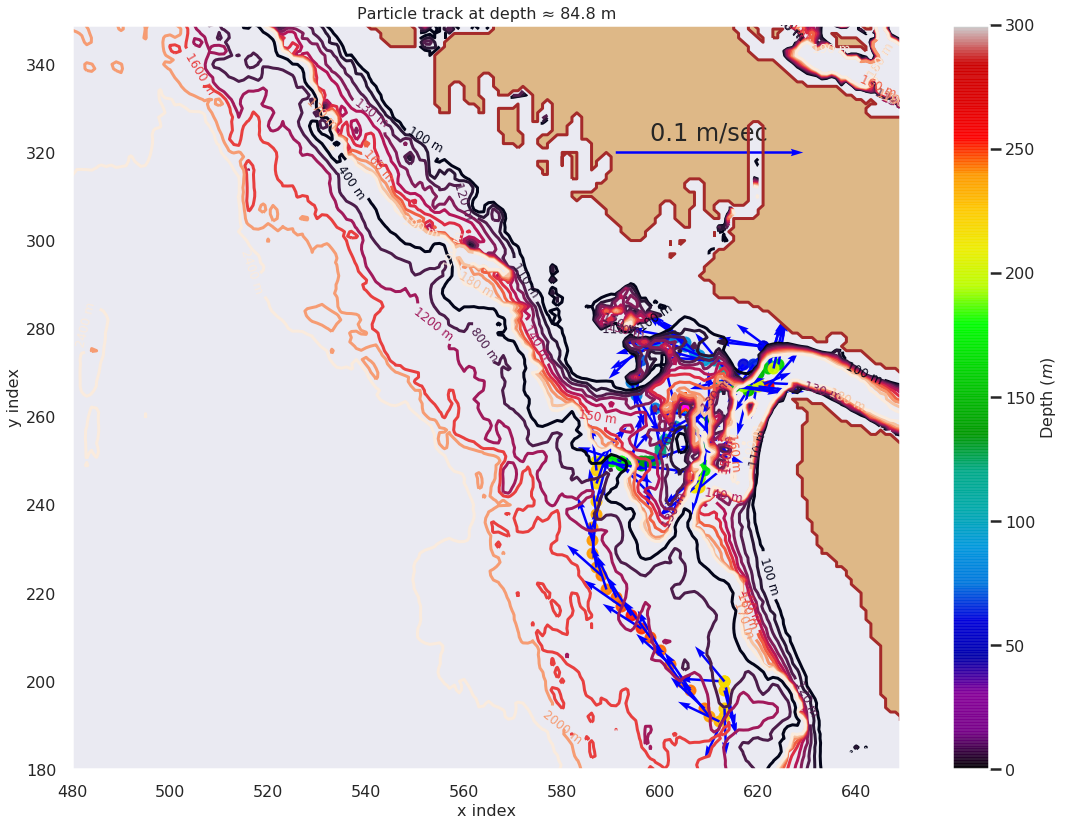

In [106]:
bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]



file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

lon_small = file_model.variables['nav_lon'][1:,1:]
lat_small = file_model.variables['nav_lat'][1:,1:]




cmap=plt.cm.get_cmap('nipy_spectral')
#     cmap = plt.cm.get_cmap('gist_rainbow')
cmap.set_bad('#8b7765')
cmin = 0
cmax = 300

import matplotlib as mpl
#     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)


# part = ind[0]
# for part in ind[139]:
part = ind[200]
for k in np.arange(0,np.int(final_age_days[part]),30):
    y, x = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                  lon,lat,grid='NEMO',tols=\
                                  {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                   'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
    track1 = ax.scatter(x_wcvi_slice[np.int(np.rint(x1[part]))-1], y_wcvi_slice[np.int(np.rint(y1[part]))-1], s=500, marker = '*', c = 'magenta', alpha=0.9, edgecolor= 'orangered')
    q = ax.scatter(x, y, c = np.multiply(-1,np.ma.array(traj_depth[k,part]).filled()), cmap = cmap, vmin = cmin, vmax= cmax, s=100, alpha=0.9)#, edgecolor= 'cyan')

    t = np.int(np.rint(120 - traj_time[k,part]*120))
    level = np.int(np.rint((np.abs(zlevels - (-traj_depth[k,part]))).argmin()))

    u_vel_time_level = u_vel[t-1,level,...]
    v_vel_time_level = v_vel[t-1,level,...]
    # for level in np.arange(zlevels.shape[0]):
    u_tzyx[...], v_tzyx[...] = viz_tools.unstagger(u_vel_time_level, v_vel_time_level)

    j, i = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                              lon_small,lat_small,grid='NEMO',tols=\
                                              {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                               'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 

    # u_tzyx_loc = np.empty((zlevels.shape[0]))
    # v_tzyx_loc = np.empty_like(u_tzyx_loc)

    u_tzyx_loc = u_tzyx[t-1,level,j,i]
    v_tzyx_loc = v_tzyx[t-1,level,j,i]
    
    speeds = np.sqrt(np.square(u_tzyx_loc) + np.square(v_tzyx_loc))
#     quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step,::arrow_step], pivot='mid', cmap = cmap, width=0.005, minshaft= 0.5)
    quiver = ax.quiver(x, y, u_tzyx_loc, v_tzyx_loc , color = 'blue', cmap = cmap, pivot='tail', width=0.003, minshaft= 0.5)
#     legend = ax.legend(loc='best', fancybox=True, framealpha=0.25, fontsize =16)
ax.quiverkey(quiver, 610, 320,  0.1, r'0.1 m/sec', coordinates = 'data')

ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)


ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
ax.legend(loc = 'best')

viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

ax.grid()

cbar = fig.colorbar(q, ax=ax)
cbar.set_label(label='Depth ($m$)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)
fig.tight_layout()





In [79]:
u_tzyx[...], v_tzyx[...] = viz_tools.unstagger(u_vel_time_level, v_vel_time_level)

In [102]:
np.int(final_age_days[ind[139]])

2534

In [16]:
traj_tem[3920,3]

8.8573523

In [13]:
final_age[:]/3600

masked_array(data = [1846.6635264434826 194.91257343959563 153.45676790559958 ...,
 1109.0450502253502 2856.0 2553.9802918649366],
             mask = [False False False ..., False False False],
       fill_value = 1e+20)

In [14]:
final_age_days[1]

194.91257343959563

In [16]:
traj_depth[194,1]

-16.544212279388468

In [19]:
final_z[1]

11.645220840332163

In [21]:
zlevels[10]

15.810073

In [5]:
traj_tem_last   = np.empty_like(final_age_days)
traj_sal_last   = np.empty_like(final_age_days)
traj_rho_last   = np.empty_like(final_age_days)
traj_depth_last = np.empty_like(final_age_days)


for r in np.arange(traj_tem_last.shape[0]):
    traj_tem_last[r]  =  traj_tem[np.int(final_age_days[r]),r]
    traj_sal_last[r]  =  traj_sal[np.int(final_age_days[r]),r]
    traj_rho_last[r]  =  traj_rho[np.int(final_age_days[r]),r]
    traj_depth_last[r] = traj_depth[np.int(final_age_days[r]),r]
    

In [33]:
traj_depth_last[(final_z > 28) & (((x_final < 630) & (y_final < 200)) & ((x_final > 580) & (y_final < 200)))].shape[0]\
/final_z.shape[0]

0.08201701093560146

In [24]:
final_z[((x_final < 630) & (y_final < 200)) & \
                                       ((x_final > 580) & (y_final < 200))].shape

(1950,)

In [25]:
np.where(final_z > 28)

masked_array(data = [ 12.63632353  11.64522084   3.69103179 ...,  26.28350247  28.68625703
  24.86870324],
             mask = False,
       fill_value = 1e+20)

In [138]:
final_z.shape

(6584,)

In [141]:
np.where(final_z[((x_final < 630) & (y_final < 200)) & \
                                       ((x_final > 580) & (y_final < 200))]>28)[0][40]

112

In [143]:
final_z

masked_array(data = [ 12.63632353  11.64522084   3.69103179 ...,  26.28350247  28.68625703
  24.86870324],
             mask = False,
       fill_value = 1e+20)

In [125]:
traj_depth_last[9]

-1.401167451587074

In [49]:
traj_tem_final_cuc = traj_tem_last[(final_z > 28) & (((x_final < 630) & (y_final < 200)) & \
                                                         ((x_final > 580) & (y_final < 200)))]

traj_sal_final_cuc = traj_sal_last[(final_z > 28) & (((x_final < 630) & (y_final < 200)) & \
                                                         ((x_final > 580) & (y_final < 200)))]

traj_rho_final_cuc = traj_rho_last[(final_z > 28) & (((x_final < 630) & (y_final < 200)) & \
                                                         ((x_final > 580) & (y_final < 200)))]


traj_depth_final_cuc = traj_depth_last[(final_z > 28) & (((x_final < 630) & (y_final < 200)) & \
                                                         ((x_final > 580) & (y_final < 200)))]

traj_tem_final_cuc = traj_tem_final_cuc[~(traj_tem_final_cuc == 1.0000000200408773e+20)]

traj_sal_final_cuc = traj_sal_final_cuc[~(traj_sal_final_cuc == 1.0000000200408773e+20)]

traj_depth_final_cuc  = traj_depth_final_cuc[~(traj_rho_final_cuc == 1.0000000200408773e+20)]
traj_rho_final_cuc    = traj_rho_final_cuc[~(traj_rho_final_cuc == 1.0000000200408773e+20)]


traj_tem_final_north = traj_tem_last[((x_final < 580) & (y_final > 300))]
traj_tem_final_north = traj_tem_final_north[~(traj_tem_final_north == 1.0000000200408773e+20)]

traj_sal_final_north = traj_sal_last[((x_final < 580) & (y_final > 300))]
traj_sal_final_north = traj_sal_final_north[~(traj_sal_final_north == 1.0000000200408773e+20)]

traj_rho_final_north = traj_rho_last[((x_final < 580) & (y_final > 300))]
traj_depth_final_north = traj_depth_last[((x_final < 580) & (y_final > 300))]

traj_depth_final_north  = traj_depth_final_north[~(traj_rho_final_north == 1.0000000200408773e+20)]
traj_rho_final_north = traj_rho_final_north[~(traj_rho_final_north == 1.0000000200408773e+20)]


traj_tem_final_south = traj_tem_last[(final_z <= 28) & (((x_final < 630) & (y_final < 200)) & \
                                                         ((x_final > 580) & (y_final < 200)))]

traj_sal_final_south = traj_sal_last[(final_z <= 28) & (((x_final < 630) & (y_final < 200)) & \
                                                         ((x_final > 580) & (y_final < 200)))]

traj_rho_final_south = traj_rho_last[(final_z <= 28) & (((x_final < 630) & (y_final < 200)) & \
                                                         ((x_final > 580) & (y_final < 200)))]

traj_depth_final_south = traj_depth_last[(final_z <= 28) & (((x_final < 630) & (y_final < 200)) & \
                                                         ((x_final > 580) & (y_final < 200)))]


traj_tem_final_south = traj_tem_final_south[~(traj_tem_final_south == 1.0000000200408773e+20)]

traj_sal_final_south = traj_sal_final_south[~(traj_sal_final_south == 1.0000000200408773e+20)]


traj_depth_final_south = traj_depth_final_south[~(traj_rho_final_south == 1.0000000200408773e+20)]
traj_rho_final_south = traj_rho_final_south[~(traj_rho_final_south == 1.0000000200408773e+20)]


traj_tem_final_juan = traj_tem_last[(x_final > 635)]
traj_tem_final_juan = traj_tem_final_juan[~(traj_tem_final_juan == 1.0000000200408773e+20)]

traj_sal_final_juan = traj_sal_last[(x_final > 635)]
traj_sal_final_juan = traj_sal_final_juan[~(traj_sal_final_juan == 1.0000000200408773e+20)]

traj_rho_final_juan = traj_rho_last[(x_final > 635)]

traj_depth_final_juan = traj_depth_last[(x_final > 635)]

traj_depth_final_juan = traj_depth_final_juan[~(traj_rho_final_juan == 1.0000000200408773e+20)]
traj_rho_final_juan = traj_rho_final_juan[~(traj_rho_final_juan == 1.0000000200408773e+20)]



x = [520,575]
y = [320,200]

coefficients = np.polyfit(x, y, 1)
x_final_off = np.arange(x[0],x[1])
polynomial = np.poly1d(coefficients)
y_final_off = np.rint(polynomial(x_final_off))

num = np.where((y_final[x_final_off] < y_final_off))[0].shape[0] + np.where((x_final<x_final_off[0]) & \
                                                                      ((y_final > 200)&(y_final<320)))[0].shape[0]

traj_tem_final_off = []
traj_tem_final_off = np.append(arr=traj_tem_final_off, \
                               values= traj_tem_last[np.where((y_final[x_final_off] < y_final_off))[0]])
traj_tem_final_off = np.append(arr=traj_tem_final_off, \
                               values = traj_tem_last[np.where((x_final<x_final_off[0]) & \
                                                               ((y_final > 200)&(y_final<320)))[0]])
traj_tem_final_off = traj_tem_final_off[~(traj_tem_final_off == 1.0000000200408773e+20)]

traj_sal_final_off = []
traj_sal_final_off = np.append(arr=traj_sal_final_off, \
                               values= traj_sal_last[np.where((y_final[x_final_off] < y_final_off))[0]])
traj_sal_final_off = np.append(arr=traj_sal_final_off, \
                               values = traj_sal_last[np.where((x_final<x_final_off[0]) & \
                                                               ((y_final > 200)&(y_final<320)))[0]])
traj_sal_final_off = traj_sal_final_off[~(traj_sal_final_off == 1.0000000200408773e+20)]


traj_rho_final_off = []

traj_rho_final_off = np.append(arr=traj_rho_final_off, \
                               values= traj_rho_last[np.where((y_final[x_final_off] < y_final_off))[0]])
traj_rho_final_off = np.append(arr=traj_rho_final_off, \
                               values = traj_rho_last[np.where((x_final<x_final_off[0]) & \
                                                               ((y_final > 200)&(y_final<320)))[0]])


traj_depth_final_off = []
traj_depth_final_off = np.append(arr=traj_depth_final_off, \
                               values= traj_depth_last[np.where((y_final[x_final_off] < y_final_off))[0]])
traj_depth_final_off = np.append(arr=traj_depth_final_off, \
                               values = traj_depth_last[np.where((x_final<x_final_off[0]) & \
                                                               ((y_final > 200)&(y_final<320)))[0]])

traj_depth_final_off = traj_depth_final_off[~(traj_rho_final_off == 1.0000000200408773e+20)]

traj_rho_final_off = traj_rho_final_off[~(traj_rho_final_off == 1.0000000200408773e+20)]

In [50]:
sns.set_context('talk')

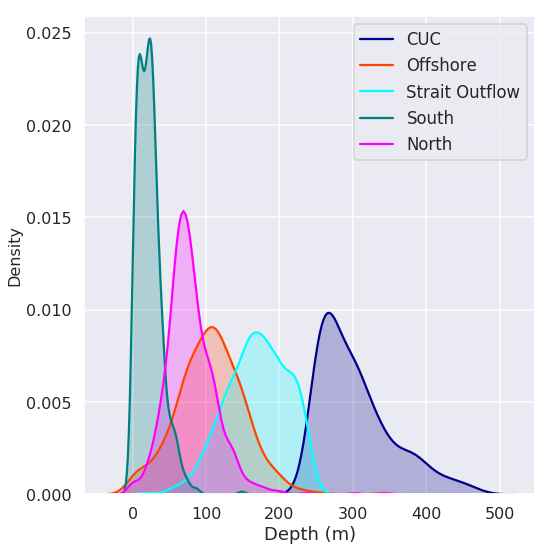

In [51]:
df = pd.DataFrame()

df['Depth CUC']     = -traj_depth_final_cuc


dp = pd.DataFrame()

dp['Depth OFF']     = -traj_depth_final_off


dg = pd.DataFrame()

dg['Depth South']     = -traj_depth_final_south


dh = pd.DataFrame()

dh['Depth Juan']     = -traj_depth_final_juan

dz = pd.DataFrame()

dz['Depth North']    = -traj_depth_final_north



fig, (ax1) = plt.subplots(1,1, figsize=(8,8))

# g = df.plot.scatter(x="Observed temperature (deg C)", y="Corrected temperature (deg C)", c = "Depth (m)", ax = ax, norm = norm, cmap = cmap, vmin = cmin, vmax = cmax, alpha = 0.5)

q = sns.kdeplot(df['Depth CUC'], ax = ax1, shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Depth OFF'], ax = ax1, shade=True, color = 'orangered', label = 'Offshore')

sns.kdeplot(dg['Depth South'], ax = ax1, shade= True, color = 'Cyan', label = 'Strait Outflow')

sns.kdeplot(dh['Depth Juan'], ax = ax1, shade=True, color = 'Teal', label = 'South')

sns.kdeplot(dz['Depth North'], ax = ax1, shade=True, color = 'Magenta', label = 'North')

# p = sns.relplot(x="Observed_temp", y="Model_temp", hue="Depth (m)",  sizes=(1,10), data=df, legend='brief', palette=cmo.cm.amp_r)

q.figure.axes[-1].yaxis.label.set_size(16)
q.figure.axes[-1].tick_params(labelsize=16) 

lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]


ax1.legend()
# ax1.tick_params(axis='both',labelsize =16)
# ax1.set_xlabel('Temperature', fontsize = 16)
# ax1.set_ylabel('Density', fontsize = 16)
# ax1.set_xlim(6,14)
ax1.set_xlabel('Depth (m)')
ax1.set_ylabel('Density')
ax1.grid()


fig.tight_layout()


### Calculate the spice

In [62]:
pressure_loc_cuc = np.empty_like(traj_depth_final_cuc)
SA_loc_cuc       = np.empty_like(traj_depth_final_cuc)
CT_loc_cuc       = np.empty_like(traj_depth_final_cuc)
spic_loc_cuc     = np.empty_like(traj_depth_final_cuc)



for i in np.arange(traj_depth_final_cuc.shape[0]):
    
    pressure_loc_cuc[i] = gsw.p_from_z(traj_depth_final_cuc[i],np.mean(traj_lat))
    
    SA_loc_cuc[i] = gsw.SA_from_SP(traj_sal_final_cuc[i], pressure_loc_cuc[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_cuc[i] = gsw.CT_from_pt(traj_sal_final_cuc[i], traj_tem_final_cuc[i])
    
    spic_loc_cuc[i] = gsw.spiciness0(SA_loc_cuc[i], CT_loc_cuc[i])

In [63]:
pressure_loc_off = np.empty_like(traj_depth_final_off)
SA_loc_off       = np.empty_like(traj_depth_final_off)
CT_loc_off       = np.empty_like(traj_depth_final_off)
spic_loc_off     = np.empty_like(traj_depth_final_off)



for i in np.arange(traj_depth_final_off.shape[0]):
    
    pressure_loc_off[i] = gsw.p_from_z(traj_depth_final_off[i],np.mean(traj_lat))
    
    SA_loc_off[i] = gsw.SA_from_SP(traj_sal_final_off[i], pressure_loc_off[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_off[i] = gsw.CT_from_pt(traj_sal_final_off[i], traj_tem_final_off[i])
    
    spic_loc_off[i] = gsw.spiciness0(SA_loc_off[i], CT_loc_off[i])

In [64]:
pressure_loc_south = np.empty_like(traj_depth_final_south)
SA_loc_south       = np.empty_like(traj_depth_final_south)
CT_loc_south       = np.empty_like(traj_depth_final_south)
spic_loc_south     = np.empty_like(traj_depth_final_south)



for i in np.arange(traj_depth_final_south.shape[0]):
    
    pressure_loc_south[i] = gsw.p_from_z(traj_depth_final_south[i],np.mean(traj_lat))
    
    SA_loc_south[i] = gsw.SA_from_SP(traj_sal_final_south[i], pressure_loc_south[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_south[i] = gsw.CT_from_pt(traj_sal_final_south[i], traj_tem_final_south[i])
    
    spic_loc_south[i] = gsw.spiciness0(SA_loc_south[i], CT_loc_south[i])
    
pressure_loc_north= np.empty_like(traj_depth_final_north)
SA_loc_north       = np.empty_like(traj_depth_final_north)
CT_loc_north       = np.empty_like(traj_depth_final_north)
spic_loc_north     = np.empty_like(traj_depth_final_north)



for i in np.arange(traj_depth_final_north.shape[0]):
    
    pressure_loc_north[i] = gsw.p_from_z(traj_depth_final_north[i],np.mean(traj_lat))
    
    SA_loc_north[i] = gsw.SA_from_SP(traj_sal_final_north[i], pressure_loc_north[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_north[i] = gsw.CT_from_pt(traj_sal_final_north[i], traj_tem_final_north[i])
    
    spic_loc_north[i] = gsw.spiciness0(SA_loc_north[i], CT_loc_north[i])
    

pressure_loc_juan= np.empty_like(traj_depth_final_juan)
SA_loc_juan       = np.empty_like(traj_depth_final_juan)
CT_loc_juan       = np.empty_like(traj_depth_final_juan)
spic_loc_juan     = np.empty_like(traj_depth_final_juan)



for i in np.arange(traj_depth_final_juan.shape[0]):
    
    pressure_loc_juan[i] = gsw.p_from_z(traj_depth_final_juan[i],np.mean(traj_lat))
    
    SA_loc_juan[i] = gsw.SA_from_SP(traj_sal_final_juan[i], pressure_loc_juan[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_juan[i] = gsw.CT_from_pt(traj_sal_final_juan[i], traj_tem_final_juan[i])
    
    spic_loc_juan[i] = gsw.spiciness0(SA_loc_juan[i], CT_loc_juan[i])
    

In [133]:
sns.set_context('talk')

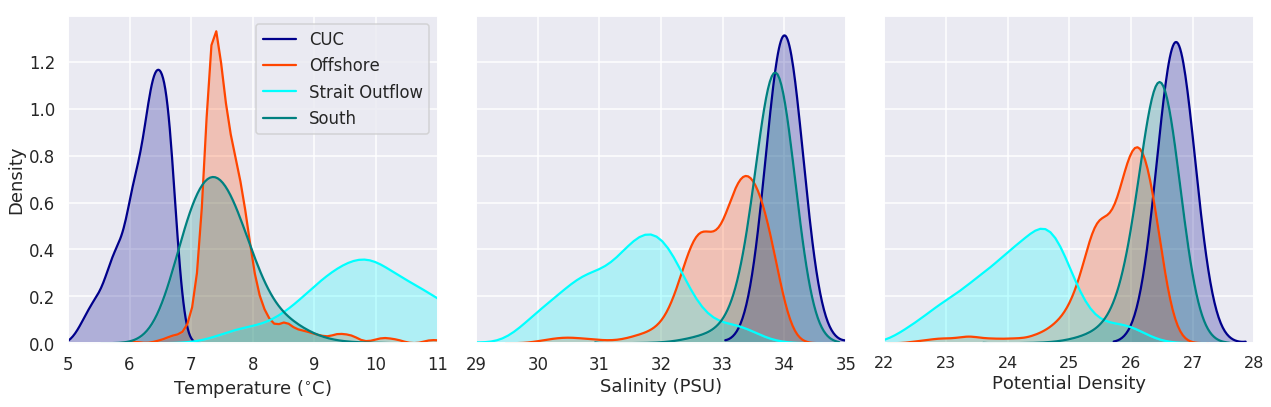

In [77]:
df = pd.DataFrame()

df['Density CUC']     = traj_rho_final_cuc
df['Temperature CUC'] = traj_tem_final_cuc
df['Salinity CUC']    = traj_sal_final_cuc

dp = pd.DataFrame()

dp['Density OFF']     = traj_rho_final_off
dp['Temperature OFF'] = traj_tem_final_off
dp['Salinity OFF']    = traj_sal_final_off

dg = pd.DataFrame()

dg['Density South']     = traj_rho_final_south
dg['Temperature South'] = traj_tem_final_south
dg['Salinity South']    = traj_sal_final_south

dh = pd.DataFrame()

dh['Density Juan']     = traj_rho_final_juan
dh['Temperature Juan'] = traj_tem_final_juan
dh['Salinity Juan']    = traj_sal_final_juan


fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,6), sharey = True)

# g = df.plot.scatter(x="Observed temperature (deg C)", y="Corrected temperature (deg C)", c = "Depth (m)", ax = ax, norm = norm, cmap = cmap, vmin = cmin, vmax = cmax, alpha = 0.5)

q = sns.kdeplot(df['Temperature CUC'], ax = ax1, bw = 0.1, shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Temperature OFF'], ax = ax1, shade=True, color = 'orangered', label = 'Offshore')

sns.kdeplot(dh['Temperature Juan'], ax = ax1, shade= True, color = 'Cyan', label = 'Strait Outflow')

sns.kdeplot(dg['Temperature South'], ax = ax1, bw = 0.3, shade=True, color = 'Teal', label = 'South')

# p = sns.relplot(x="Observed_temp", y="Model_temp", hue="Depth (m)",  sizes=(1,10), data=df, legend='brief', palette=cmo.cm.amp_r)

q.figure.axes[-1].yaxis.label.set_size(16)
q.figure.axes[-1].tick_params(labelsize=16) 

lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]


ax1.legend()
# ax1.tick_params(axis='both',labelsize =16)
# ax1.set_xlabel('Temperature', fontsize = 16)
# ax1.set_ylabel('Density', fontsize = 16)
ax1.set_xlim(5,11)
ax1.set_xlabel('Temperature ($^{\circ}$C)')
ax1.set_ylabel('Density')
ax1.grid()


q = sns.kdeplot(df['Salinity CUC'], ax = ax2, bw=0.3, shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Salinity OFF'], ax = ax2, shade=True,color = 'orangered', label = 'Offshore')

sns.kdeplot(dh['Salinity Juan'], ax = ax2, shade= True, color = 'Cyan', label = 'Strait Outflow')

sns.kdeplot(dg['Salinity South'], ax = ax2, bw=0.3, shade=True, color = 'Teal', label = 'South')

# p = sns.relplot(x="Observed_temp", y="Model_temp", hue="Depth (m)",  sizes=(1,10), data=df, legend='brief', palette=cmo.cm.amp_r)

q.figure.axes[-1].yaxis.label.set_size(16)
q.figure.axes[-1].tick_params(labelsize=16) 


# ax1.legend()
# ax1.tick_params(axis='both',labelsize =16)
# ax1.set_xlabel('Temperature', fontsize = 16)
# ax1.set_ylabel('Density', fontsize = 16)
ax2.set_xlim(29,35)
ax2.set_xlabel('Salinity (PSU)')
# ax2.set_ylabel('Density')
ax2.grid()
ax2.get_legend().remove()


q = sns.kdeplot(df['Density CUC'], ax = ax3, bw=0.3, shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Density OFF'], ax = ax3, shade=True,color = 'orangered', label = 'Offshore')

sns.kdeplot(dh['Density Juan'], ax = ax3, shade= True, color = 'Cyan', label = 'Strait Outflow')

sns.kdeplot(dg['Density South'], ax = ax3, bw= 0.3, shade=True, color = 'Teal', label = 'South')

# p = sns.relplot(x="Observed_temp", y="Model_temp", hue="Depth (m)",  sizes=(1,10), data=df, legend='brief', palette=cmo.cm.amp_r)

q.figure.axes[-1].yaxis.label.set_size(16)
q.figure.axes[-1].tick_params(labelsize=16) 


# ax1.legend()
# ax1.tick_params(axis='both',labelsize =16)
# ax1.set_xlabel('Temperature', fontsize = 16)
# ax1.set_ylabel('Density', fontsize = 16)
ax3.set_xlim(22,28)
ax3.set_xlabel('Potential Density')
# ax2.set_ylabel('Density')
ax3.grid()
ax3.get_legend().remove()

fig.tight_layout()


# q.figure.axes[-1].yaxis.label.set_size(16)
# q.figure.axes[-1].tick_params(labelsize=16) 

# plt.savefig(path_to_save+'fit_temp.png')

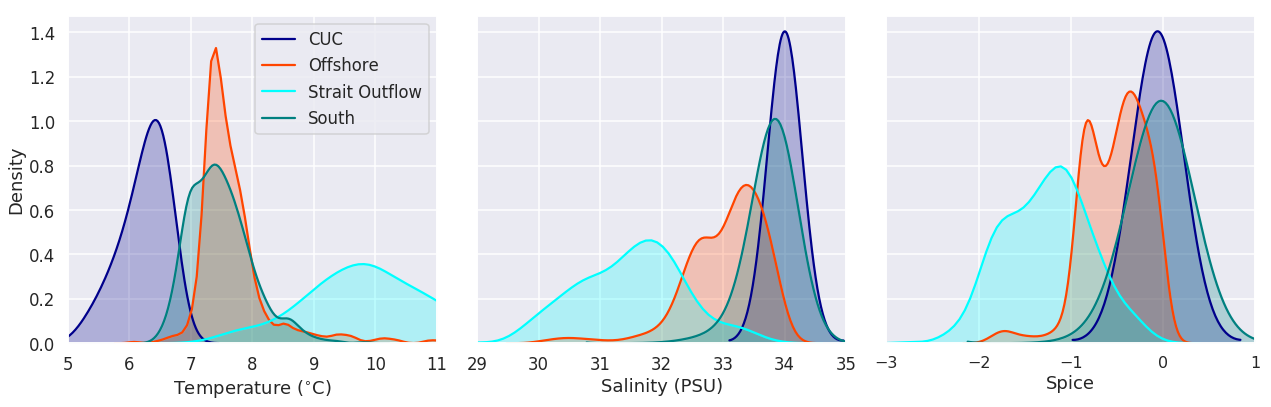

In [76]:
df = pd.DataFrame()

df['Density CUC']     = traj_rho_final_cuc
df['Temperature CUC'] = traj_tem_final_cuc
df['Salinity CUC']    = traj_sal_final_cuc
df['Spice CUC']       = spic_loc_cuc

dp = pd.DataFrame()

dp['Density OFF']     = traj_rho_final_off
dp['Temperature OFF'] = traj_tem_final_off
dp['Salinity OFF']    = traj_sal_final_off
dp['Spice OFF']       = spic_loc_off

dg = pd.DataFrame()

dg['Density South']     = traj_rho_final_south
dg['Temperature South'] = traj_tem_final_south
dg['Salinity South']    = traj_sal_final_south
dg['Spice South']       = spic_loc_south

dh = pd.DataFrame()

dh['Density Juan']     = traj_rho_final_juan
dh['Temperature Juan'] = traj_tem_final_juan
dh['Salinity Juan']    = traj_sal_final_juan
dh['Spice Juan']       = spic_loc_juan



fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,6), sharey = True)

# g = df.plot.scatter(x="Observed temperature (deg C)", y="Corrected temperature (deg C)", c = "Depth (m)", ax = ax, norm = norm, cmap = cmap, vmin = cmin, vmax = cmax, alpha = 0.5)

q = sns.kdeplot(df['Temperature CUC'], ax = ax1, bw = 0.2, shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Temperature OFF'], ax = ax1, shade=True, color = 'orangered', label = 'Offshore')

sns.kdeplot(dh['Temperature Juan'], ax = ax1, shade= True, color = 'Cyan', label = 'Strait Outflow')

sns.kdeplot(dg['Temperature South'], ax = ax1, shade=True, color = 'Teal', label = 'South')

# p = sns.relplot(x="Observed_temp", y="Model_temp", hue="Depth (m)",  sizes=(1,10), data=df, legend='brief', palette=cmo.cm.amp_r)

q.figure.axes[-1].yaxis.label.set_size(16)
q.figure.axes[-1].tick_params(labelsize=16) 

lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]


ax1.legend()
# ax1.tick_params(axis='both',labelsize =16)
# ax1.set_xlabel('Temperature', fontsize = 16)
# ax1.set_ylabel('Density', fontsize = 16)
ax1.set_xlim(5,11)
ax1.set_xlabel('Temperature ($^{\circ}$C)')
ax1.set_ylabel('Density')
ax1.grid()


q = sns.kdeplot(df['Salinity CUC'], ax = ax2, bw= 0.28, shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Salinity OFF'], ax = ax2, shade=True,color = 'orangered', label = 'Offshore')

sns.kdeplot(dh['Salinity Juan'], ax = ax2, shade= True, color = 'Cyan', label = 'Strait Outflow')

sns.kdeplot(dg['Salinity South'], ax = ax2, bw = 0.35, shade=True, color = 'Teal', label = 'South')

# p = sns.relplot(x="Observed_temp", y="Model_temp", hue="Depth (m)",  sizes=(1,10), data=df, legend='brief', palette=cmo.cm.amp_r)

q.figure.axes[-1].yaxis.label.set_size(16)
q.figure.axes[-1].tick_params(labelsize=16) 


# ax1.legend()
# ax1.tick_params(axis='both',labelsize =16)
# ax1.set_xlabel('Temperature', fontsize = 16)
# ax1.set_ylabel('Density', fontsize = 16)
ax2.set_xlim(29,35)
ax2.set_xlabel('Salinity (PSU)')
# ax2.set_ylabel('Density')
ax2.grid()
ax2.get_legend().remove()


q = sns.kdeplot(df['Spice CUC'], ax = ax3, bw=0.28, shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Spice OFF'], ax = ax3, shade=True,color = 'orangered', label = 'Offshore')

sns.kdeplot(dh['Spice Juan'], ax = ax3, shade= True, color = 'Cyan', label = 'Strait Outflow')

sns.kdeplot(dg['Spice South'], ax = ax3, bw = 0.35, shade=True, color = 'Teal', label = 'South')

# p = sns.relplot(x="Observed_temp", y="Model_temp", hue="Depth (m)",  sizes=(1,10), data=df, legend='brief', palette=cmo.cm.amp_r)

q.figure.axes[-1].yaxis.label.set_size(16)
q.figure.axes[-1].tick_params(labelsize=16) 


# ax1.legend()
# ax1.tick_params(axis='both',labelsize =16)
# ax1.set_xlabel('Temperature', fontsize = 16)
# ax1.set_ylabel('Density', fontsize = 16)
ax3.set_xlim(-3,1)
ax3.set_xlabel('Spice')
# ax2.set_ylabel('Density')
ax3.grid()
ax3.get_legend().remove()

fig.tight_layout()


# q.figure.axes[-1].yaxis.label.set_size(16)
# q.figure.axes[-1].tick_params(labelsize=16) 

# plt.savefig(path_to_save+'fit_temp.png')

In [61]:
num_north = np.round(a=final_age[(x_final < 580) & (y_final > 300)].shape[0]/final_z.shape[0], decimals=3)

north_percent = 100*num_north

print(north_percent)

num_cuc = np.round(a=np.where(final_z[((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200))]>28)[0].shape[0]/final_z.shape[0], decimals = 3)

cuc_percent = 100*num_cuc

print(cuc_percent)

num_south = np.round(a=np.where(final_z[((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200))]<=28)[0].shape[0]/final_z.shape[0], decimals = 3)

south_percent = 100*num_south

print(south_percent)

### Bigger box
x = [520,575]
y = [320,200]


coefficients = np.polyfit(x, y, 1)

x_final_off = np.arange(x[0],x[1])
polynomial = np.poly1d(coefficients)
y_final_off = np.rint(polynomial(x_final_off))



num = np.where((y_final[x_final_off] < y_final_off))[0].shape[0] + np.where((x_final<x_final_off[0]) & \
                                                                      ((y_final > 200)&(y_final<320)))[0].shape[0]

num_off = num/final_z.shape[0]
off_percent = np.round(a=100*num_off, decimals=1)

print(off_percent)

num_juan = np.round(a=np.where((x_final > 635))[0].shape[0]/final_z.shape[0], decimals=3)

juan_percent = num_juan*100

print(juan_percent)

13.3
8.2
21.4
10.0
9.2


In [50]:
sns.set_context('talk')

In [51]:
def plot_pie_diagram(off_percentage, south_percentage, cuc_percentage, juan_percentage, north_percentage):

    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][...]
    lat = bathy['nav_lat'][...]




    cmap=plt.cm.get_cmap('nipy_spectral')
    #     cmap = plt.cm.get_cmap('gist_rainbow')
    cmap.set_bad('#8b7765')
    cmin = 0
    cmax = 300

    import matplotlib as mpl
    #     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

    fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
    CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
    CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)


    # # part = ind[0]
    # for part in ind[-5:-1]:
    #     for k in np.arange(traj_depth.shape[0]):
    #         y, x = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
    #                                       lon,lat,grid='NEMO',tols=\
    #                                       {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
    #                                        'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
    #         track1 = ax.scatter(x_wcvi_slice[np.int(np.rint(x1[part]))-1], y_wcvi_slice[np.int(np.rint(y1[part]))-1], s=500, marker = '*', c = 'magenta', alpha=0.9, edgecolor= 'orangered')
    #         q = ax.scatter(x, y, c = np.multiply(-1,np.ma.array(traj_depth[k,part]).filled()), cmap = cmap, vmin = cmin, vmax= cmax, s=10, alpha=0.5)#, edgecolor= 'cyan')



    ax.set_xlabel('x index', fontsize =16)
    ax.set_ylabel('y index', fontsize = 16)
    ax.tick_params(axis='both',labelsize =16)


    # ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
    ax.legend(loc = 'best')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

    x = [520,575]
    y = [320,200]
    ax.plot(x, y , 'bo-')

    xmin = x_wcvi_slice[np.int(np.min(np.unique(x1)))]-1
    xmax = x_wcvi_slice[np.int(np.max(np.unique(x1)))]-1


    ymin = y_wcvi_slice[np.int(np.min(np.unique(y1)))]-1
    ymax  = y_wcvi_slice[np.int(np.max(np.unique(y1)))]-1


    x_1 = [xmin, xmax]
    y_1 = [ymin, ymin]
    ax.plot(x_1, y_1 , 'go-')

    x_2 = [xmin, xmax]
    y_2 = [ymax, ymax]
    ax.plot(x_2, y_2 , 'go-')

    x_3 = [xmin, xmin]
    y_3 = [ymin, ymax]
    ax.plot(x_3, y_3 , 'go-')

    x_4 = [xmax, xmax]
    y_4 = [ymin, ymax]
    ax.plot(x_4, y_4 , 'go-')

    ax.vlines(x = 635, ymin = 261, ymax = 279, color = 'blue')

    # ax.get_legend().remove()
    lon_LB08 = -125.4775
    lat_LB08 = 48.4217

    j, i = geo_tools.find_closest_model_point(lon_LB08,lat_LB08,\
                                              lon,lat,grid='NEMO',tols=\
                                              {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                               'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 

    ax.scatter(i,j, marker = 'o', c = 'red', s = 300, linewidths=100, label = 'Eddy region')

    ax.hlines(y = 200, xmin = 575, xmax=645, color = 'b')
    ax.hlines(y = 320, xmin = 520, xmax=590, color = 'b')
    ax.grid()

    axins = inset_axes(ax, width="50%", height="75%",
                       bbox_to_anchor=(.085, .18, .5, .5),
                       bbox_transform=ax.transAxes, loc=3)
    axins.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)

    axins.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)


    labels = 'Offshore', 'From South', 'CUC','Strait outflow', 'From North', 'Shelf water'
    sizes = [off_percentage, south_percentage, cuc_percentage, juan_percentage, north_percentage, \
             100- (off_percentage + south_percentage + cuc_percentage + juan_percentage + north_percentage)]
    explode = (0, 0.1, 0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

    # fig, ax = plt.subplots(figsize=(30, 10), subplot_kw=dict(aspect="equal"))

    size = 0.35
    vals = np.array([[9.5, 0], [10.2, 0], [12.3, 0], [25.4, 51.7-25.4]])

    cmap = plt.get_cmap("tab20c")
    outer_colors = cmap(np.arange(4)*4)
    inner_colors = cmap(np.arange(5)*4)#cmap(np.array([1, 4, 7, 10, 13, 25]))

    axins.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    axins.axis('equal') 
    # axins.set_title("Particles at all depths")

    # # For visualization purposes we mark the bounding box by a rectangle
    # ax.add_patch(plt.Rectangle((.2, .4), .6, .5, ls="--", ec="c", fc="None",
    #                            transform=ax.transAxes))

    # ax.legend(loc = 'best')
    # cbar = fig.colorbar(q, ax=ax)
    # cbar.set_label(label='Depth ($m$)', fontsize = 16)
    # cbar.ax.tick_params(labelsize=16)
    fig.tight_layout()





For all the particles


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


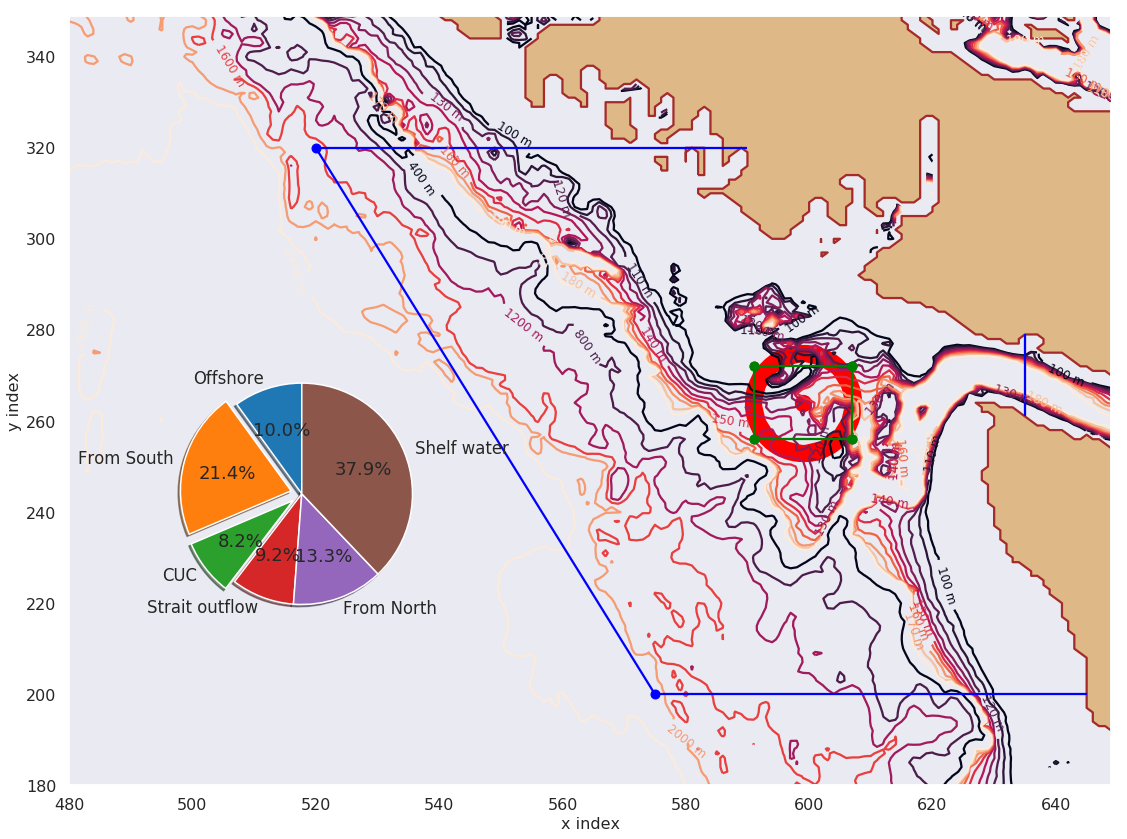

In [62]:
print("For all the particles")


plot_pie_diagram(cuc_percentage=cuc_percent, juan_percentage=juan_percent, \
                 north_percentage=north_percent, south_percentage=south_percent, \
                 off_percentage=off_percent)

In [59]:
### For the top 21m

part_0 = np.where(init_z[:] <14)[0].shape[0]

print(part_0)

num_south = np.where(init_z[np.where(((x_final < 630) & (y_final < 200)) & ((x_final > 580) & (y_final < 200)))[0]]< 14)[0].shape[0]

south_percent = np.round(a=100*(num_south/part_0), decimals=1)

print(south_percent)

num_cuc = np.where(final_z[np.where(init_z[np.where(((x_final < 630) & (y_final < 200)) & \
                                                 ((x_final > 580) & (y_final < 200)))[0]]< 14)[0]] > 27)[0].shape[0]
cuc_percent = np.round(a=100*(num_cuc/part_0), decimals=1)

print(cuc_percent)

num_north = np.where(init_z[np.where((x_final < 580) & (y_final > 300))[0]] < 14)[0].shape[0]

north_percent = np.round(a=100*(num_north/part_0), decimals=1)

print(north_percent)

num_off = np.where(init_z[y_final_off[np.where((y_final[x_final_off] < y_final_off))[0]].astype(int)] < 14)[0].shape[0] + \
np.where(init_z[np.where((x_final<x_final_off[0]) & ((y_final > 200)&(y_final<320)))] < 14)[0].shape[0]

off_percent = np.round(a=100*(num_off/part_0), decimals=1)

print(off_percent)


num_juan = np.where(init_z[np.where((x_final > 635))[0]] < 14)[0].shape[0]

juan_percent = np.round(a=100*(num_juan/part_0), decimals=1)

print(juan_percent)


3757
21.2
4.6
16.0
10.2
12.3


For top 21 m


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


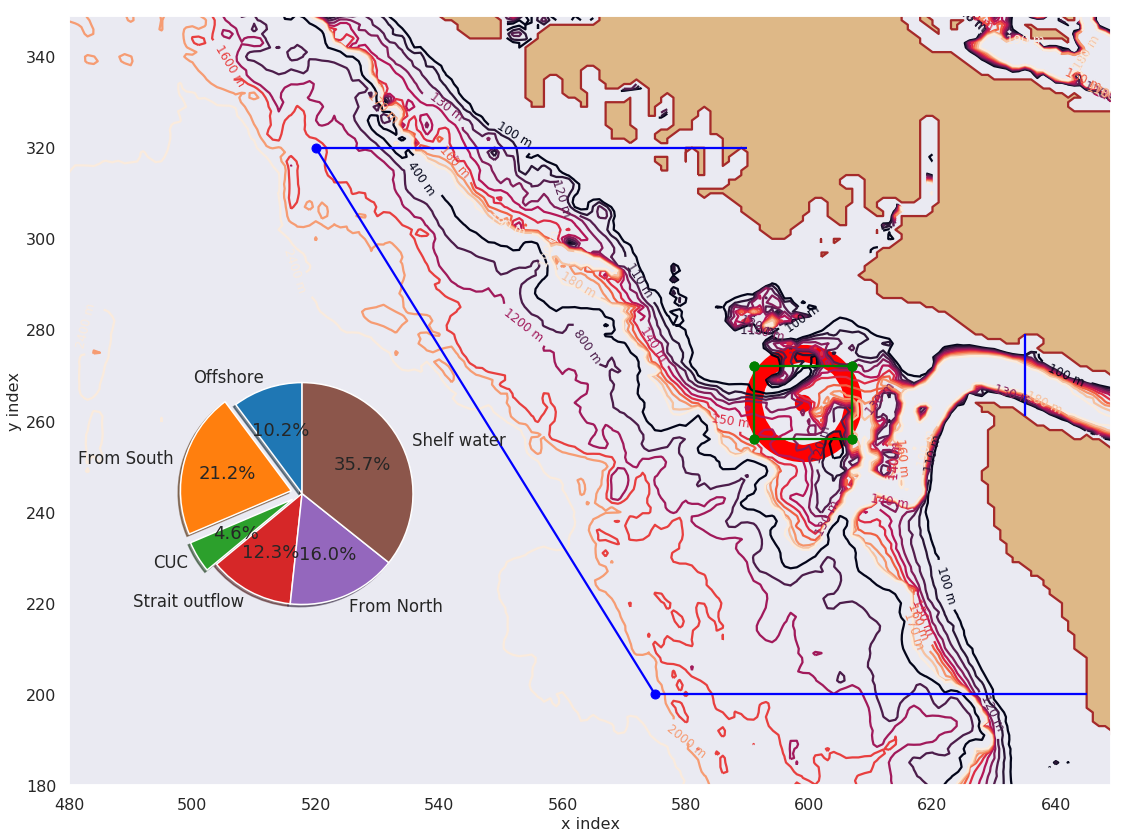

In [60]:
print("For top 21 m")

plot_pie_diagram(cuc_percentage=cuc_percent, juan_percentage=juan_percent, \
                 north_percentage=north_percent, south_percentage=south_percent, \
                 off_percentage=off_percent)

In [67]:
part_0 = np.where((init_z[:] >= 14) &(init_z[:] < 21))[0].shape[0]

print(part_0)

num_south = np.where((init_z[np.where(((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200)))[0]] >= 14) & \
                     (init_z[np.where(((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200)))[0]] < 21))[0].shape[0]

south_percent = np.round(a=100*(num_south/part_0), decimals=1)

print(south_percent)

num_cuc = np.where(final_z[np.where((init_z[np.where(((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200)))[0]] >= 14) & \
                     (init_z[np.where(((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200)))[0]] < 21))[0]] > 27)[0].shape[0]
cuc_percent = np.round(a=100*(num_cuc/part_0), decimals=1)
print(cuc_percent)

num_north = np.where((init_z[np.where((x_final < 580) & (y_final > 300))[0]] >= 14) & \
                    (init_z[np.where((x_final < 580) & (y_final > 300))[0]] < 21))[0].shape[0]


north_percent = np.round(a=100*(num_north/part_0), decimals=1)

print(north_percent)

num_off = np.where((init_z[y_final_off[np.where((y_final[x_final_off] < y_final_off))[0]].astype(int)] >= 14) & \
          (init_z[y_final_off[np.where((y_final[x_final_off] < y_final_off))[0]].astype(int)] < 21))[0].shape[0] + \
np.where((init_z[np.where((x_final<x_final_off[0]) & ((y_final > 200)&(y_final<320)))] >= 14) & \
(init_z[np.where((x_final<x_final_off[0]) & ((y_final > 200)&(y_final<320)))] < 21))[0].shape[0]

off_percent = np.round(a=100*(num_off/part_0), decimals=1)

print(off_percent)

num_juan = np.where((init_z[np.where((x_final > 635))[0]] >= 14) & \
                   (init_z[np.where((x_final > 635))[0]] < 21))[0].shape[0]

juan_percent = np.round(a=100*(num_juan/part_0), decimals=1)

print(juan_percent)
                                    

2023
37.4
8.5
11.1
10.6
6.4


From 21 m to 65m


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


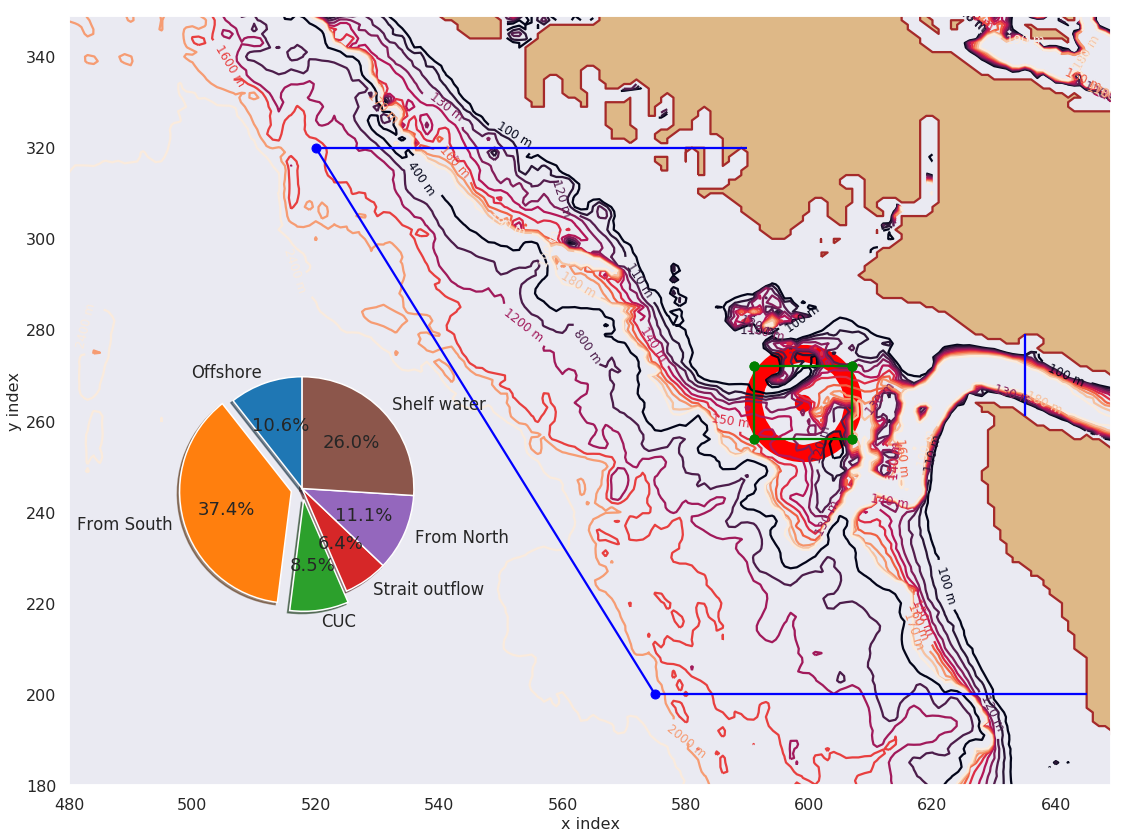

In [69]:
print("From 21 m to 65m")

plot_pie_diagram(cuc_percentage=cuc_percent, juan_percentage=juan_percent, \
                 north_percentage=north_percent, south_percentage=south_percent, \
                 off_percentage=off_percent)

In [71]:
part_0 = np.where(init_z[:] >=21)[0].shape[0]

print(part_0)


num_south = np.where(init_z[np.where(((x_final < 630) & (y_final < 200)) & ((x_final > 580) & (y_final < 200)))[0]]>=21)[0].shape[0]
south_percent = np.round(a=100*(num_south/part_0), decimals=1)

print(south_percent)

num_cuc = np.where(final_z[np.where(init_z[np.where(((x_final < 630) & (y_final < 200)) & \
                                                 ((x_final > 580) & (y_final < 200)))[0]] >=21)[0]] > 27)[0].shape[0]
cuc_percent = np.round(a=100*(num_cuc/part_0), decimals=1)
print(cuc_percent)

num_north = np.where(init_z[np.where((x_final < 580) & (y_final > 300))[0]] >=21)[0].shape[0]
north_percent = np.round(a=100*(num_north/part_0), decimals=1)

print(north_percent)

num_off = np.where(init_z[y_final_off[np.where((y_final[x_final_off] < y_final_off))[0]].astype(int)] >= 21)[0].shape[0] + \
np.where(init_z[np.where((x_final<x_final_off[0]) & ((y_final > 200)&(y_final<320)))] >= 21)[0].shape[0]

off_percent = np.round(a=100*(num_off/part_0), decimals=1)

print(off_percent)

num_juan = np.where(init_z[np.where((x_final > 635))[0]] >= 21)[0].shape[0]

juan_percent = np.round(a=100*(num_juan/part_0), decimals=1)

print(juan_percent)



804
49.3
9.8
5.8
7.1
1.9


From 65 m to 155m


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


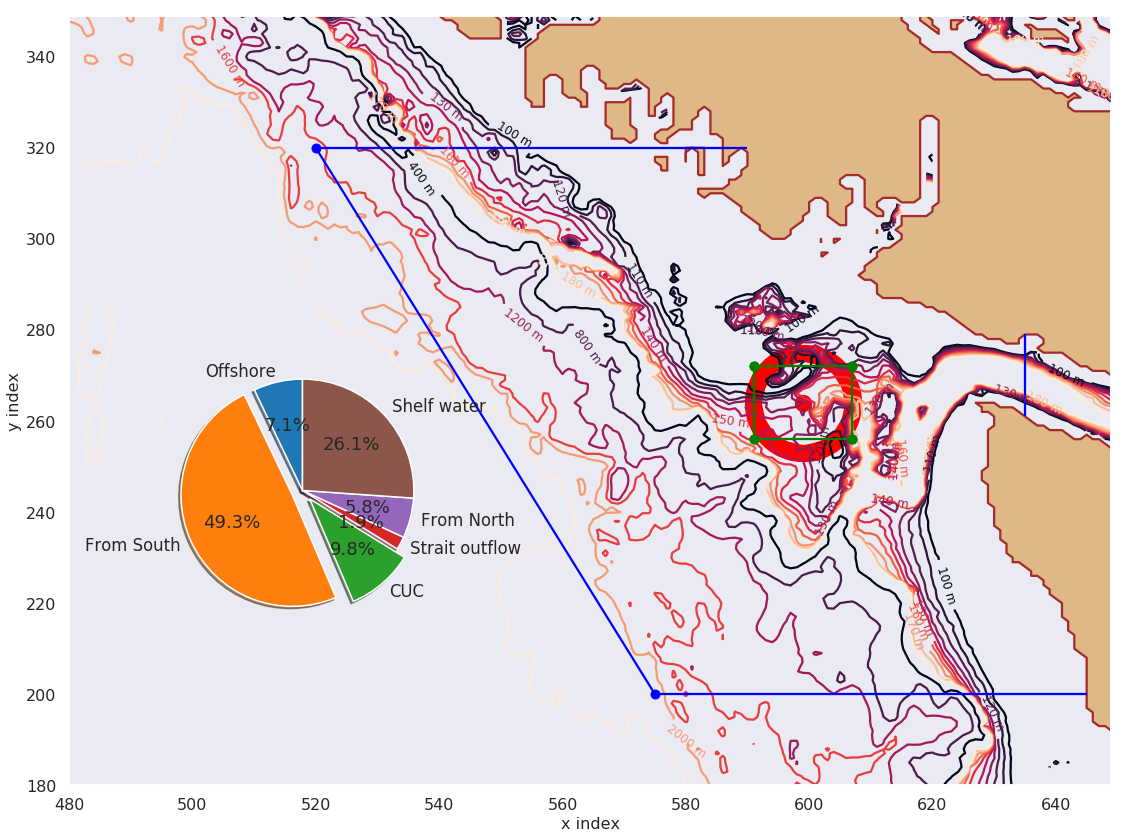

In [72]:
print("From 65 m to 155m")

plot_pie_diagram(cuc_percentage=cuc_percent, juan_percentage=juan_percent, \
                 north_percentage=north_percent, south_percentage=south_percent, \
                 off_percentage=off_percent)

### What is the percentage of particles that have been upwelled ?

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


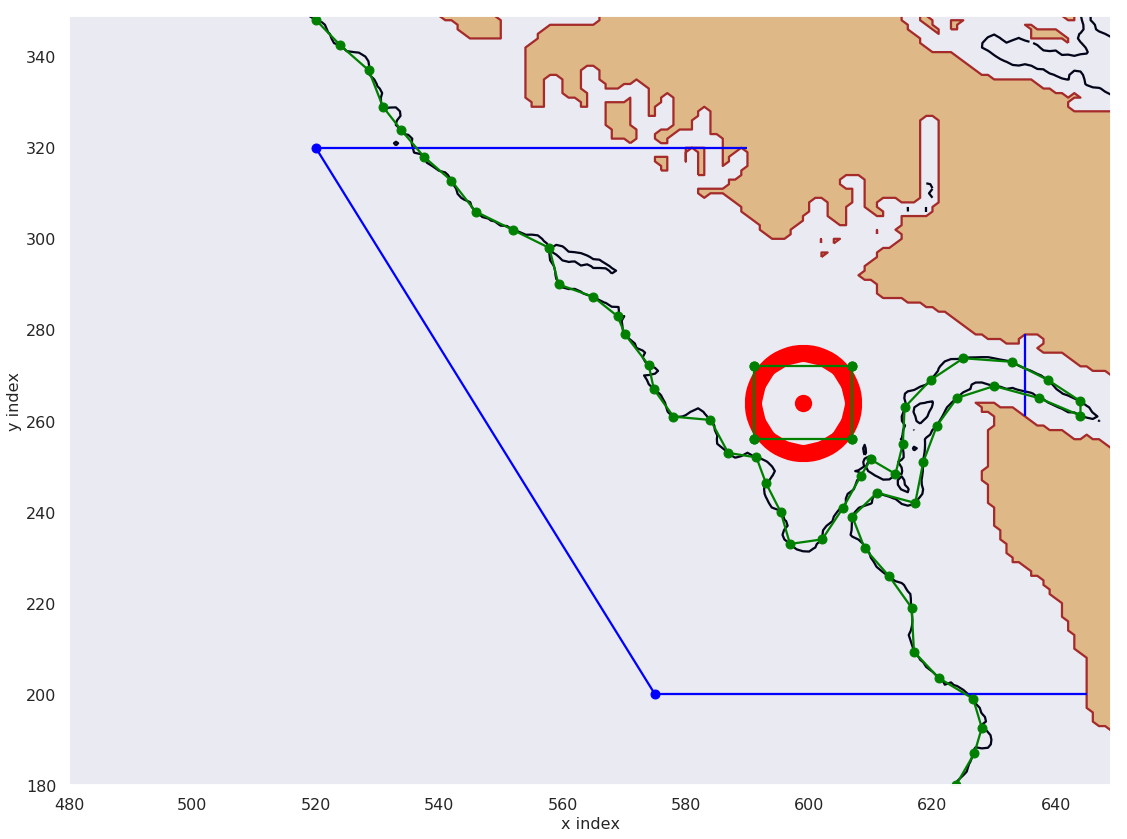

In [77]:



bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]




cmap=plt.cm.get_cmap('nipy_spectral')
#     cmap = plt.cm.get_cmap('gist_rainbow')
cmap.set_bad('#8b7765')
cmin = 0
cmax = 300

import matplotlib as mpl
#     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10))
# CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
# CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
# CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)


# ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
ax.legend(loc = 'best')

viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

x = [520,575]
y = [320,200]
ax.plot(x, y , 'bo-')

xmin = x_wcvi_slice[np.int(np.min(np.unique(x1)))]-1
xmax = x_wcvi_slice[np.int(np.max(np.unique(x1)))]-1


ymin = y_wcvi_slice[np.int(np.min(np.unique(y1)))]-1
ymax  = y_wcvi_slice[np.int(np.max(np.unique(y1)))]-1


x_1 = [xmin, xmax]
y_1 = [ymin, ymin]
ax.plot(x_1, y_1 , 'go-')

x_2 = [xmin, xmax]
y_2 = [ymax, ymax]
ax.plot(x_2, y_2 , 'go-')

x_3 = [xmin, xmin]
y_3 = [ymin, ymax]
ax.plot(x_3, y_3 , 'go-')

x_4 = [xmax, xmax]
y_4 = [ymin, ymax]
ax.plot(x_4, y_4 , 'go-')

ax.vlines(x = 635, ymin = 261, ymax = 279, color = 'blue')

# ax.get_legend().remove()
lon_LB08 = -125.4775
lat_LB08 = 48.4217

j, i = geo_tools.find_closest_model_point(lon_LB08,lat_LB08,\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 

ax.scatter(i,j, marker = 'o', c = 'red', s = 300, linewidths=100, label = 'Eddy region')

ax.hlines(y = 200, xmin = 575, xmax=645, color = 'b')
ax.hlines(y = 320, xmin = 520, xmax=590, color = 'b')
ax.grid()


# for i in range(0, len(x_200_wcvi), 10):
#     plt.plot(x_200_wcvi[i:i+1], y_200_wcvi[i:i+1], 'mo-')
    

Line = ax.plot(x_200_wcvi[::10], y_200_wcvi[::10], 'go-')
fig.tight_layout()





In [60]:
contour = CS.collections[0]
vs = contour.get_paths()[0].vertices


In [78]:
vert = CS.collections[0].get_paths()[0].vertices

x_200_wcvi = vert[:,0]
y_200_wcvi = vert[:,1]



In [81]:
def find_index(k):
    
    indice = np.zeros(final_age.shape[0])
    
    for m in np.arange(traj_lon.shape[1]):

        y, x = geo_tools.find_closest_model_point(traj_lon[k,m],traj_lat[k,m],\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
        y1,x1 = geo_tools.find_closest_model_point(traj_lon[k-500,m],traj_lat[k-500,m],\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

        bbox = mpl.transforms.Bbox(points=[(x,y), (x1,y1)]) 

        if (mpl.path.Path(vertices=vert).intersects_bbox(bbox, filled=True)) == True:
    #         if ((np.max(-traj_depth[:,m]) >= 200) & (np.max(-traj_depth[:,m]) < 200)):
    #         indice = np.append(arr=indice, values=[[k], [m]], axis=0)
            indice[m] = m
    #         indice[:,m] = k
    #         indice = np.append(arr=indice, values=[m], axis=1)

        else:
            continue

    indexes = np.array(np.nonzero(indice))
    
    return indexes[0]

def generate_polygon(points):
    p = []
    p.append(points[0][1])
    
    for point in points:
        p.append(point[0])
        p.append(points[-1][1])
        
    for point in points[::-1]:
        p.append(point[2])
        eclipse_boundary = Polygon(p)
        
    p = []
    
    for point in points:
        p.append(point[1])
        center_line = LineString(p)
        
    return eclipse_boundary, center_line 
        
    

def point_in_hull(point, hull, tolerance=1e-12):
    return all(
        (np.dot(eq[:-1], point) + eq[-1] <= tolerance)
        for eq in hull.equations)


In [80]:
IK = find_index(500)

PK = find_index(1000)

LK = find_index(1500)

JK = find_index(2000)

LI = find_index(2500)

LP = find_index(3000)

MN = find_index(3500)

total_indi = np.concatenate((IK,PK,LK,JK,LI, LP, MN))

In [82]:
cross_index = []


for i in np.unique(total_indi):

    if ((np.max(-traj_depth[:,i]) >= 200) & (np.min(-traj_depth[:,i]) < 200)) == True:
        
        cross_index = np.append(arr=cross_index, values=i)
        


In [83]:
cross_index.shape[0]/final_z.shape[0]

0.3516099635479951

### 35 Percent of the total particles have arrived as a result of shelf break upwelling

In [84]:

from scipy.spatial import ConvexHull

x_b = [564, 583, 597, 597, 575, 564]
y_b = [252, 267, 262, 258, 248, 252]

points = np.stack((x_b, y_b), axis=-1)

    
hull_barkley = ConvexHull((points))

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


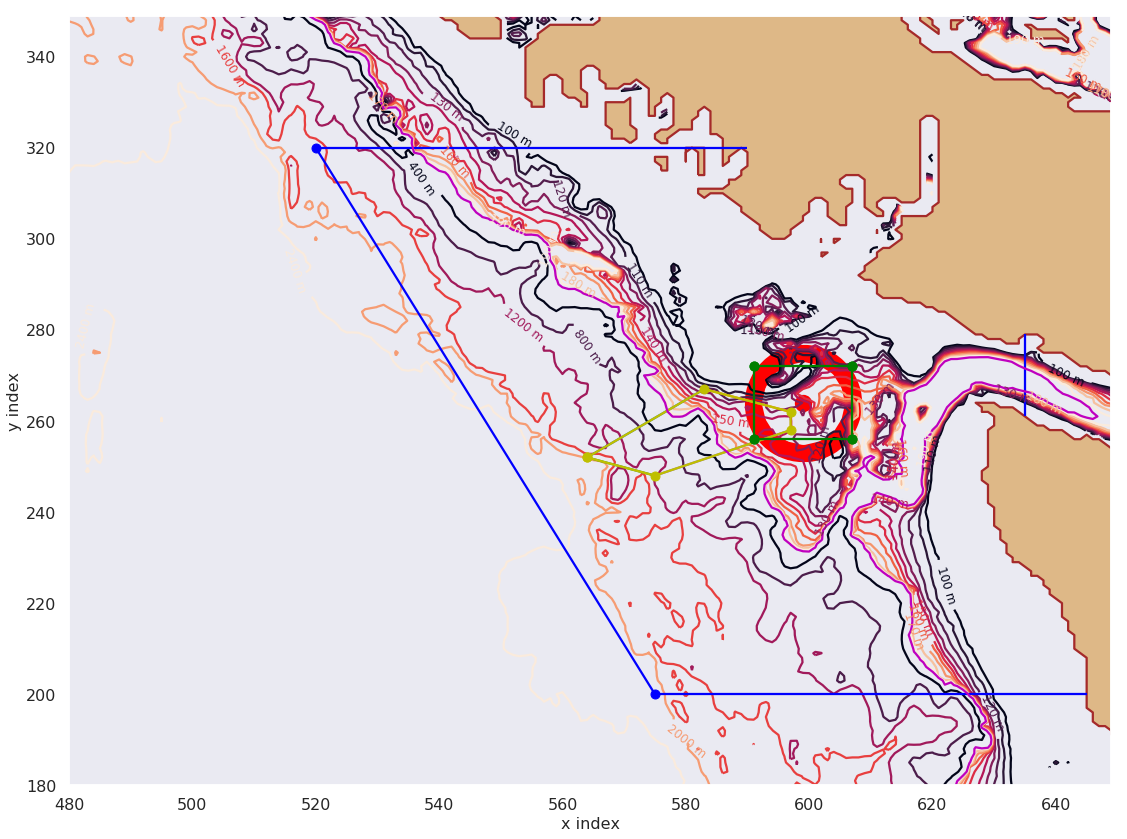

In [85]:



bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]




cmap=plt.cm.get_cmap('nipy_spectral')
#     cmap = plt.cm.get_cmap('gist_rainbow')
cmap.set_bad('#8b7765')
cmin = 0
cmax = 300

import matplotlib as mpl
#     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)


# ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
ax.legend(loc = 'best')

viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

x = [520,575]
y = [320,200]
ax.plot(x, y , 'bo-')



for simplex in hull_barkley.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1])



ax.plot(x_b, y_b , 'yo-')

xmin = x_wcvi_slice[np.int(np.min(np.unique(x1)))]-1
xmax = x_wcvi_slice[np.int(np.max(np.unique(x1)))]-1


ymin = y_wcvi_slice[np.int(np.min(np.unique(y1)))]-1
ymax  = y_wcvi_slice[np.int(np.max(np.unique(y1)))]-1


x_1 = [xmin, xmax]
y_1 = [ymin, ymin]
ax.plot(x_1, y_1 , 'go-')

x_2 = [xmin, xmax]
y_2 = [ymax, ymax]
ax.plot(x_2, y_2 , 'go-')

x_3 = [xmin, xmin]
y_3 = [ymin, ymax]
ax.plot(x_3, y_3 , 'go-')

x_4 = [xmax, xmax]
y_4 = [ymin, ymax]
ax.plot(x_4, y_4 , 'go-')

ax.vlines(x = 635, ymin = 261, ymax = 279, color = 'blue')

# ax.get_legend().remove()
lon_LB08 = -125.4775
lat_LB08 = 48.4217

j, i = geo_tools.find_closest_model_point(lon_LB08,lat_LB08,\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 

ax.scatter(i,j, marker = 'o', c = 'red', s = 300, linewidths=100, label = 'Eddy region')

ax.hlines(y = 200, xmin = 575, xmax=645, color = 'b')
ax.hlines(y = 320, xmin = 520, xmax=590, color = 'b')
ax.grid()


# for i in range(0, len(x_200_wcvi), 10):
#     plt.plot(x_200_wcvi[i:i+1], y_200_wcvi[i:i+1], 'mo-')
    

Line = ax.plot(x_200_wcvi[::1], y_200_wcvi[::1], 'm-')
fig.tight_layout()





In [86]:
# indices_max_diff = np.empty((cross_index.shape[0], cross_index.shape[0]))

indices_max_diff = []

for i in cross_index:
    j = np.max(np.where(np.diff(-traj_depth[:,np.int(i)]) == np.max(np.diff(-traj_depth[:,np.int(i)])))[0])
    indices_max_diff = np.append(arr=indices_max_diff, values=np.int(j))
    

In [87]:
y_max_depth = np.empty_like(indices_max_diff)
x_max_depth = np.empty_like(indices_max_diff)

for p in np.arange(indices_max_diff.shape[0]):
    
    y_max_depth[p], x_max_depth[p] = geo_tools.find_closest_model_point(traj_lon[np.int(indices_max_diff[p]-1),np.int(cross_index[p])],\
                                                                        traj_lat[np.int(indices_max_diff[p]-1),np.int(cross_index[p])],\
                                                                        lon,lat,grid='NEMO',\
                                                                        tols={'NEMO': {'tol_lon': 0.1, \
                                                                                       'tol_lat': 0.1},\
                                                                              'GEM2.5': {'tol_lon': 0.1, \
                                                                                         'tol_lat': 0.1}})


In [88]:

from scipy.spatial import ConvexHull

points_all = np.stack((x_max_depth, y_max_depth), axis=-1)
  
    
barkley  = 0

for one_point in points_all:
    point_is_in_barkley = point_in_hull(one_point, hull_barkley)
    
    if point_is_in_barkley: 
    
        barkley =  barkley + 1
        
    else:
        continue

In [89]:
barkley/cross_index.shape[0]

0.15982721382289417

### Barkley Canyon contributes 16 percent to the total upwelling

In [81]:
from shapely.geometry import LineString

# for i in np.arange(x_200_wcvi.shape[0]-1):
#     line = LineString([(x_200_wcvi[np.arange(x_200_wcvi.shape[0]-1)], \
#                          y_200_wcvi[np.arange(x_200_wcvi.shape[0]-1)]),\
#                       (x_200_wcvi[np.arange(x_200_wcvi.shape[0]-1)+1], \
#                          y_200_wcvi[np.arange(x_200_wcvi.shape[0]-1)+1])])


AB = LineString(coordinates=[(x_200_wcvi[0],y_200_wcvi[0]), (x_200_wcvi[-1],y_200_wcvi[-1])])

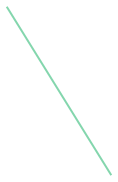

In [82]:
AB

In [8]:
import matplotlib as mpl


mpl.path.Path(vertices=vert).contains_point([519.,348.8], radius = 0.1)



True

In [9]:
indice = np.empty_like(traj_lon)

k = 1000
m = 4

# for k in np.arange(traj_lon.shape[0]-1):
for k in np.arange(-1,2,2):
    print(k)
    for m in np.arange(traj_lon.shape[1]):
#     m = 100
        y, x = geo_tools.find_closest_model_point(traj_lon[k,m],traj_lat[k,m],\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
        y1,x1 = geo_tools.find_closest_model_point(traj_lon[k+1,m],traj_lat[k+1,m],\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

        bbox = mpl.transforms.Bbox(points=[(x,y), (x1,y1)]) 

        if mpl.path.Path(vertices=vert).intersects_bbox(bbox, filled=True) == True:
    #         indice = np.append(arr=indice, values=[[k], [m]], axis=0)
            indice[k,m] = m
    #         indice[:,m] = k
    #         indice = np.append(arr=indice, values=[m], axis=1)

        else:
            continue

-1
1


In [114]:
indice = np.zeros(final_age.shape[0])

# indice = np.zeros_like(traj_lon)


# for k in np.arange(traj_lon.shape[0]-1):
# for k in np.arange(-1,2,2):
k = 2000
print(k)
for m in np.arange(traj_lon.shape[1]):
#     m = 100
    y, x = geo_tools.find_closest_model_point(traj_lon[k,m],traj_lat[k,m],\
                                  lon,lat,grid='NEMO',tols=\
                                  {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                   'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
    y1,x1 = geo_tools.find_closest_model_point(traj_lon[0,m],traj_lat[0,m],\
                                  lon,lat,grid='NEMO',tols=\
                                  {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                   'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

    bbox = mpl.transforms.Bbox(points=[(x,y), (x1,y1)]) 

    if (mpl.path.Path(vertices=vert).intersects_bbox(bbox, filled=True)) == True:
#         if ((np.max(-traj_depth[:,m]) >= 200) & (np.max(-traj_depth[:,m]) < 200)):
#         indice = np.append(arr=indice, values=[[k], [m]], axis=0)
        indice[m] = m
#         indice[:,m] = k
#         indice = np.append(arr=indice, values=[m], axis=1)

    else:
        continue

2000


In [115]:
indice

array([    0.,     0.,     0., ...,     0.,  6582.,  6583.])

In [116]:
index = np.array(np.nonzero(indice))

In [117]:
index.shape[1]/final_z.shape[0]

0.5865735115431349

### 58.6 percent of all the particles arriving at the locations near LB08 have crossed the isobath

In [81]:
cross_index = []


for i in index[0]:

    if ((np.max(-traj_depth[:,i]) >= 200) & (np.min(-traj_depth[:,i]) < 200)) == True:
        
        cross_index = np.append(arr=cross_index, values=i)

In [82]:
cross_index.shape[0]/final_z.shape[0]

0.26974483596597815

### 27 percent of all particles have been upwelled and reached the location

In [124]:
cross_index = []


for i in np.arange(traj_depth.shape[1]):

    if ((np.max(-traj_depth[:,i]) >= 200) & (np.min(-traj_depth[:,i]) < 200)) == True:
        
        cross_index = np.append(arr=cross_index, values=i)

In [125]:
cross_index.shape[0]/final_z.shape[0]

0.35662211421628187

### 35.66 percent of all particles gets upwelled

In [47]:
np.max(-traj_depth[:,index[0][0]])

111.1869979745203

In [23]:
(np.min(-traj_depth[:,500]))

46.953006412559915

In [71]:
np.nonzero(indice)[0].shape

(3862,)

In [71]:
traj_depth[6,2]

-0.99695792628817947

In [ ]:
traj_depth[:mydates.shape[0],traj_depth_level]

In [58]:
np.where(-traj_depth[:,2] == np.max(-traj_depth[:,2]))

(array([2064]),)

In [59]:
traj_depth[1000,2]

-16.190927514945216

In [60]:
traj_depth[2064,2]

-111.1869979745203

In [49]:
traj_depth[500,2]

-28.094108518240429

In [43]:
traj_depth[2002,2]

-93.822155979487661

In [206]:
x_final[4000]

598.0

In [207]:
y_final[4000]

180.0

In [124]:
bbox = mpl.transforms.Bbox(points=[(x,y), (x1,y1)]) 

In [125]:
mpl.path.Path(vertices=vert).intersects_bbox(bbox, filled=True)

True

In [126]:
x1,y1

(610, 259)

In [127]:
x,y

(565, 285)

In [58]:
traj_rho_final_cuc.shape

(471,)

In [49]:
traj_tem_final_cuc.shape

(79,)

In [28]:
np.max(traj_rho_final_cuc)

1.0000000200408773e+20

In [29]:
np.max(traj_sal_final_cuc)

1.0000000200408773e+20

In [21]:
traj_tem_last.shape

(9592,)

In [22]:
final_age_days.shape

(9592,)

In [40]:
zlevels[27]

266.04025

In [48]:
traj_tem_final_cuc[traj_tem_final_cuc > 10].shape[0]

18

In [18]:
indice1 = indice[np.nonzero(indice)]

In [73]:
np.nonzero(indice)[0].shape[0]/final_z.shape[0]

0.5865735115431349

### 58.6 percent of the total number of particles crossed the isobath

In [21]:
np.unique(total_indi).shape[0]/final_z.shape[0]

0.8816828675577156

In [14]:
np.unique(total_indi).shape[0]/final_z.shape[0]

0.8816828675577156

In [27]:
np.unique(total_indi)

array([   6,   14,   15, ..., 6581, 6582, 6583])

In [15]:
cross_index = []


for i in np.unique(total_indi):

    if ((np.max(-traj_depth[:,i]) >= 200) & (np.min(-traj_depth[:,i]) < 200)) == True:
        
        cross_index = np.append(arr=cross_index, values=i)

In [17]:
cross_index.shape[0]/final_z.shape[0]

0.3516099635479951

### 35 percent of the particles was upwelled by crossing the 200m isobaths

##### Q) What percent of the particles go through Barkley, Nitinat and Juan de Fuca (upwelling zones)

In [18]:
cross_index

array([   16.,    18.,    22., ...,  6576.,  6578.,  6582.])

In [136]:
np.where(np.diff(-traj_depth[:,16]) == np.max(np.diff(-traj_depth[:,16])))[0]

array([1176])

In [22]:
-traj_depth[1175,16]

216.7616928302491

In [23]:
-traj_depth[1178,16]

237.45888287039747

In [97]:
traj_lat[1175,16]

48.455764097696161

In [54]:
y, x = geo_tools.find_closest_model_point(traj_lon[1175,16],traj_lat[1175,16],\
                              lon,lat,grid='NEMO',tols=\
                              {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                               'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

print(y,x)

264 576


In [55]:
y, x = geo_tools.find_closest_model_point(traj_lon[2397,16],traj_lat[2397,16],\
                              lon,lat,grid='NEMO',tols=\
                              {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                               'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

print(y,x)

279 561


In [51]:
np.max(np.where(-np.ma.masked_invalid(traj_depth[:2856,16]) < 200)[0])

2397

In [53]:
traj_depth[2397,16]

-199.95313511425923

In [47]:
ttt = np.ma.filled(traj_depth[:,16], fill_value=0)

In [48]:
ttt

array([-37.2624855 , -37.34940706, -37.43063126, ...,   0.        ,
         0.        ,   0.        ])

In [49]:
np.nonzero(ttt)

(array([   0,    1,    2, ..., 2854, 2855, 2856]),)

In [67]:
def generate_polygon(points):
    p = []
    p.append(points[0][1])
    
    for point in points:
        p.append(point[0])
        p.append(points[-1][1])
        
    for point in points[::-1]:
        p.append(point[2])
        eclipse_boundary = Polygon(p)
        
    p = []
    
    for point in points:
        p.append(point[1])
        center_line = LineString(p)
        
    return eclipse_boundary, center_line 
        
    

def point_in_hull(point, hull, tolerance=1e-12):
    return all(
        (np.dot(eq[:-1], point) + eq[-1] <= tolerance)
        for eq in hull.equations)

In [163]:

from scipy.spatial import ConvexHull

# points = np.array([(x_b[:], y_b[:])])

# points = []

points = np.stack((x_b, y_b), axis=-1)

# for i in np.arange(len(x_b)-1):
#     points = np.append(arr=points, values=[(x_b[i],y_b[i])])
    
hull_barkley = ConvexHull((points))

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


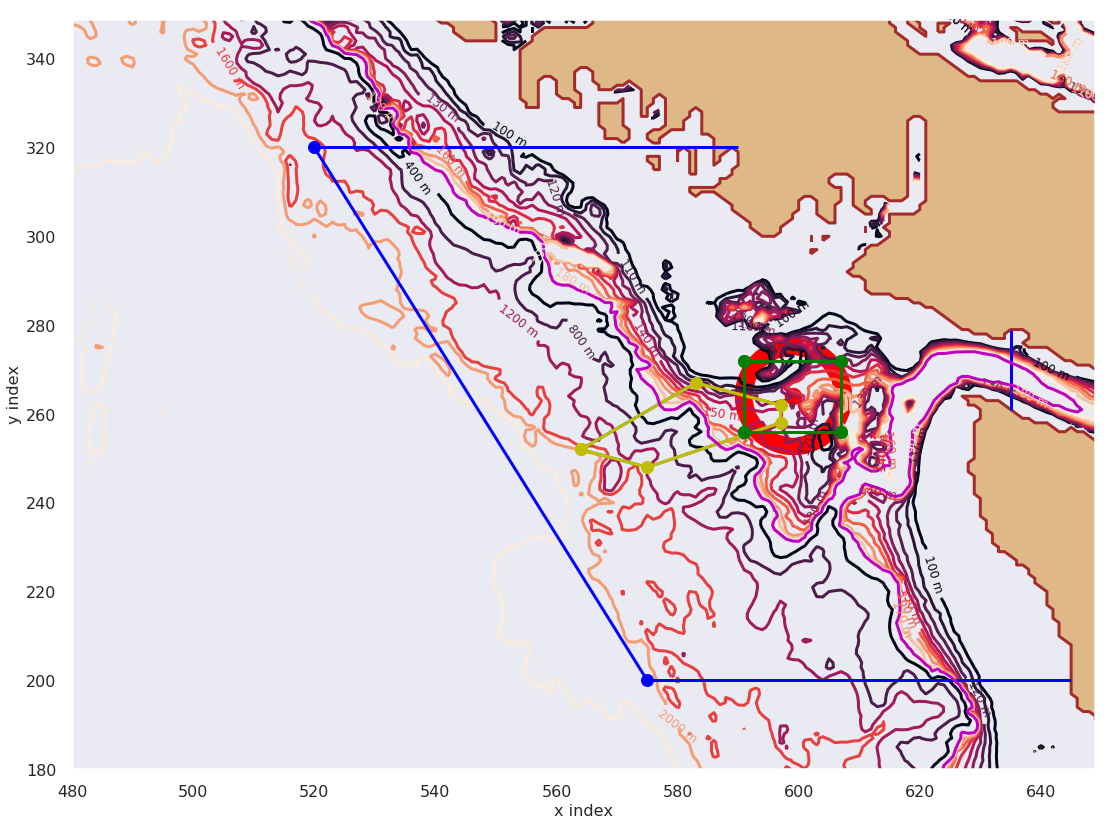

In [132]:



bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]




cmap=plt.cm.get_cmap('nipy_spectral')
#     cmap = plt.cm.get_cmap('gist_rainbow')
cmap.set_bad('#8b7765')
cmin = 0
cmax = 300

import matplotlib as mpl
#     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)


# ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
ax.legend(loc = 'best')

viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

x = [520,575]
y = [320,200]
ax.plot(x, y , 'bo-')



for simplex in hull_barkley.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1])


x_b = [564, 583, 597, 597, 575, 564]
y_b = [252, 267, 262, 258, 248, 252]
ax.plot(x_b, y_b , 'yo-')

xmin = x_wcvi_slice[np.int(np.min(np.unique(x1)))]-1
xmax = x_wcvi_slice[np.int(np.max(np.unique(x1)))]-1


ymin = y_wcvi_slice[np.int(np.min(np.unique(y1)))]-1
ymax  = y_wcvi_slice[np.int(np.max(np.unique(y1)))]-1


x_1 = [xmin, xmax]
y_1 = [ymin, ymin]
ax.plot(x_1, y_1 , 'go-')

x_2 = [xmin, xmax]
y_2 = [ymax, ymax]
ax.plot(x_2, y_2 , 'go-')

x_3 = [xmin, xmin]
y_3 = [ymin, ymax]
ax.plot(x_3, y_3 , 'go-')

x_4 = [xmax, xmax]
y_4 = [ymin, ymax]
ax.plot(x_4, y_4 , 'go-')

ax.vlines(x = 635, ymin = 261, ymax = 279, color = 'blue')

# ax.get_legend().remove()
lon_LB08 = -125.4775
lat_LB08 = 48.4217

j, i = geo_tools.find_closest_model_point(lon_LB08,lat_LB08,\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 

ax.scatter(i,j, marker = 'o', c = 'red', s = 300, linewidths=100, label = 'Eddy region')

ax.hlines(y = 200, xmin = 575, xmax=645, color = 'b')
ax.hlines(y = 320, xmin = 520, xmax=590, color = 'b')
ax.grid()


# for i in range(0, len(x_200_wcvi), 10):
#     plt.plot(x_200_wcvi[i:i+1], y_200_wcvi[i:i+1], 'mo-')
    

Line = ax.plot(x_200_wcvi[::1], y_200_wcvi[::1], 'm-')
fig.tight_layout()





In [96]:
cross_index.shape

NameError: name 'cross_index' is not defined

In [151]:
# indices_max_diff = np.empty((cross_index.shape[0], cross_index.shape[0]))

indices_max_diff = []

for i in cross_index:
    j = np.max(np.where(np.diff(-traj_depth[:,np.int(i)]) == np.max(np.diff(-traj_depth[:,np.int(i)])))[0])
    indices_max_diff = np.append(arr=indices_max_diff, values=np.int(j))
    

In [152]:
cross_index.shape

(2315,)

In [153]:
indices_max_diff.shape

(2315,)

In [158]:
y_max_depth = np.empty_like(indices_max_diff)
x_max_depth = np.empty_like(indices_max_diff)

for p in np.arange(indices_max_diff.shape[0]):
    
    y_max_depth[p], x_max_depth[p] = geo_tools.find_closest_model_point(traj_lon[np.int(indices_max_diff[p]-1),np.int(cross_index[p])],\
                                                                        traj_lat[np.int(indices_max_diff[p]-1),np.int(cross_index[p])],\
                                                                        lon,lat,grid='NEMO',\
                                                                        tols={'NEMO': {'tol_lon': 0.1, \
                                                                                       'tol_lat': 0.1},\
                                                                              'GEM2.5': {'tol_lon': 0.1, \
                                                                                         'tol_lat': 0.1}})
    

In [161]:
y_max_depth.shape

(2315,)

In [170]:

from scipy.spatial import ConvexHull

points_all = np.stack((x_max_depth, y_max_depth), axis=-1)
  
    
barkley  = 0

for one_point in points_all:
    point_is_in_barkley = point_in_hull(one_point, hull_barkley)
    
    if point_is_in_barkley: 
    
        barkley =  barkley + 1
        
    else:
        continue

In [171]:
barkley

370

In [173]:
barkley/cross_index.shape[0]

0.15982721382289417

### 15% of the upwelled particles (which are 35% of total) come through Barkley canyon

In [174]:
(15/100)*(35/100)

0.0525

In [154]:
indices_max_diff

array([ 1176.,   899.,  1251., ...,   966.,   271.,  1316.])

In [ ]:
point_is_in_hull = point_in_hull(p, hull_barkley)